# Result Notebook

## Imports

In [1]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import gc
import multimodal_mazes
import matplotlib.pyplot as plt
import h5py

## Static Training Test

In [ ]:
evaluator = multimodal_mazes.LinearPreyEvaluatorContinuous(width=51, height=59, n_steps=30, scenario='Static', case=None, motion=None, speed=0)
evaluator.run_trials(400, True)

In [ ]:
evaluator.training_plots(paths=True)

In [ ]:
evaluator.training_plots(reward=True)

In [ ]:
evaluator.training_plots(animate=True)

## Constant Movement Training Test

### Training and Testing

In [4]:
cases = ["1", "2", "3"]
speeds = np.arange(0, 2.0, 0.24)
n_agents = 1
case_colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
capture_results = np.zeros((n_agents, len(cases), len(speeds)))
approach_results = np.zeros((n_agents, len(cases), len(speeds)))           
trials = {agent: {case: {speed: {} for speed in range(len(speeds))} for case in range(len(cases))} for agent in range(n_agents)}

In [ ]:
# evaluator = multimodal_mazes.LinearPreyEvaluatorContinuous(width=51, height=59, n_steps=50, scenario='Constant', case=None, motion='Linear', speed=None)
# evaluator.run_trials(800, True)
# evaluator.training_plots(animate=True)

In [ ]:
for n in range(n_agents):
    evaluator = multimodal_mazes.LinearPreyEvaluatorContinuous(width=51, height=59, n_steps=50, scenario='Constant', case=None, motion='Linear', speed=None)
    evaluator.run_trials(800, True)
    for case in range(len(cases)):
        for a, speed in enumerate(speeds):
            test_trial_data, captured = evaluator.evaluate(n_trials=1000, case=cases[case], speed=speed)
            trials[n][case][a] = test_trial_data
            capture_results[n, case, a] = captured 

 92%|█████████▎| 925/1000 [00:09<00:00, 95.88it/s] 

### Result Processing

In [ ]:
capture_processed = np.zeros((2, len(cases), len(speeds)))
capture_results_mod = capture_results.copy()
capture_results_mod = np.delete(capture_results.copy(), [], 0)

for case in range(len(cases)):
    for speed in range(len(speeds)):
        capture_processed[0, case, speed] = np.mean(capture_results_mod[:, case, speed])
        capture_processed[1, case, speed] = np.std(capture_results_mod[:, case, speed])

print('Capture Results:')
print(capture_results)
print('Processed Capture Results:')
print(capture_processed)

Capture Results:
[[[89.9 88.2 89.9 66.7 94.4 88.8 15.1 12.1  6.2]
  [94.5 81.9 81.1 78.4 77.9 79.5 31.6 34.2 34.7]
  [88.3 96.2 97.9 93.9  2.6  0.   0.   0.   0. ]]]
Processed Capture Results:
[[[89.9 88.2 89.9 66.7 94.4 88.8 15.1 12.1  6.2]
  [94.5 81.9 81.1 78.4 77.9 79.5 31.6 34.2 34.7]
  [88.3 96.2 97.9 93.9  2.6  0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]]]


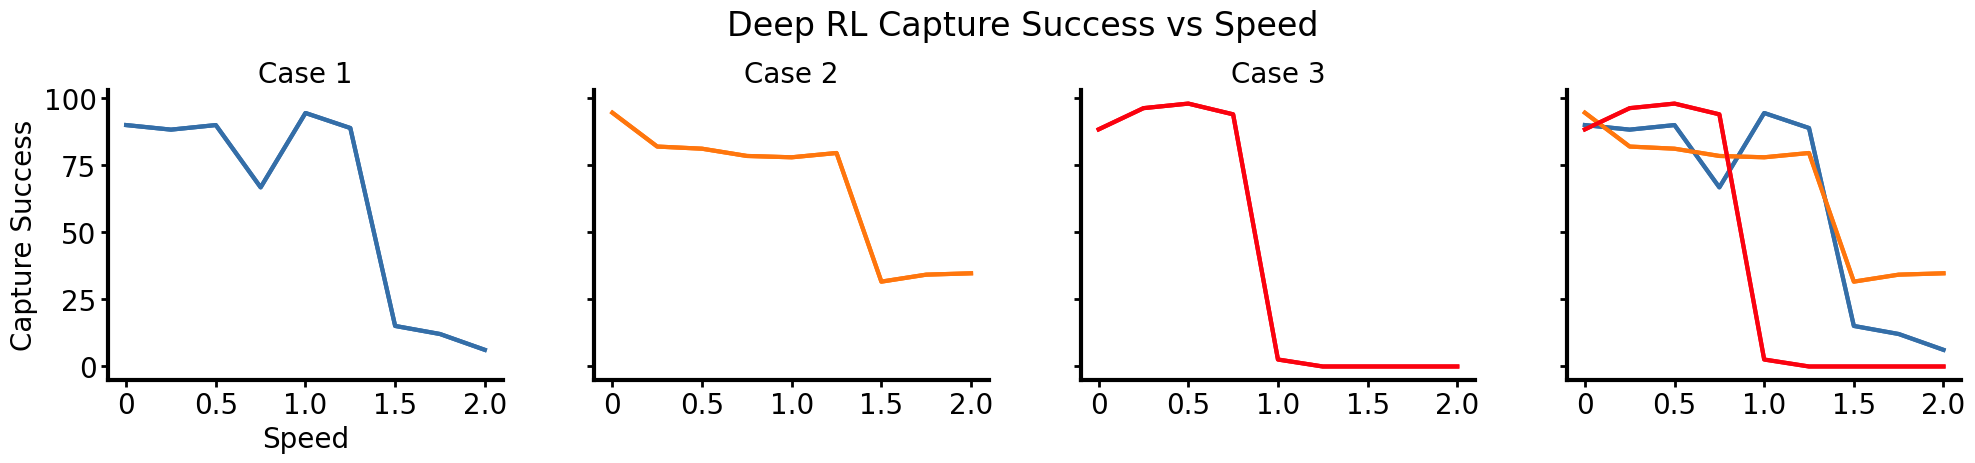

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"Deep RL Capture Success vs Speed")
    
for case in range(len(cases)):
    axs[case].set_title(f"Case {case + 1}")
    for n in range(n_agents):
        if n not in []:
            axs[case].plot(speeds, capture_results[n, case, :], color = case_colors[case], alpha = 0.2)
    
    axs[case].plot(speeds, capture_processed[0, case, :], color=case_colors[case])
    axs[case].errorbar(speeds, capture_processed[0, case, :], yerr=capture_processed[1, case, :], color=case_colors[case])
    axs[3].plot(speeds, capture_processed[0, case, :], color=case_colors[case])
    axs[3].errorbar(speeds, capture_processed[0, case, :], yerr=capture_processed[1, case, :], color=case_colors[case])
    
axs[0].set(xlabel='Speed', ylabel='Capture Success')
axs[0].set_xticks(np.arange(0, 2.0, 0.48), ['0', '0.5', '1.0', '1.5', '2.0']);

### Trajectory Plotting

In [ ]:
speeds = np.arange(0, 2.0, 0.24)

In [ ]:
colors = {0: [plt.get_cmap('Blues')(i) for i in np.arange(0, 2.0, 0.24)], 
          1: [plt.get_cmap('Oranges')(i) for i in np.arange(0, 2.0, 0.24)], 
          2: [plt.get_cmap('Reds')(i) for i in np.arange(0, 2.0, 0.24)]}

case_coords = {case: {'y': {pm: [] for pm in range(len(speeds))}, 'x': {pm: [] for pm in range(len(speeds))}} for case in range(len(cases))}
case_mean_coords = {case: {'mean_x': {pm: [] for pm in range(len(speeds))}, 'unique_y': {pm: [] for pm in range(len(speeds))}} for case in range(len(cases))}
    
for n in range(n_agents):
    for case in range(len(cases)):       
        for a in range(len(speeds)):
            x_coords, y_coords = [], []
            
            for trial in trials[n][case][a]:
                path = trials[n][case][a][trial]['path']
                for location in path:
                    y = 59 - location[0]
                    x = 51 - location[1] if path[0][1] < path[-1][1] else location[1]
                    y_coords.append(int(y))
                    x_coords.append(int(x))
                    
            case_coords[case]['y'][a] = y_coords
            case_coords[case]['x'][a] = x_coords

            x_values = np.array(x_coords)
            y_values = np.array(y_coords)
            unique_ys = np.unique(y_values)

            mean_xs = np.array([x_values[y_values == y].mean() for y in unique_ys])
            case_mean_coords[case]['mean_x'][a] = mean_xs
            case_mean_coords[case]['unique_y'][a] = unique_ys


In [ ]:
for a in range(len(speeds)):
    plt.plot(case_mean_coords[0]['mean_x'][a], case_mean_coords[0]['unique_y'][a], label=np.round(speeds[a], 1), color=colors[0][a])
    
plt.title('Case 1')
plt.axis("off")        
plt.legend()

In [ ]:
for a in range(len(speeds)):
    plt.plot(case_mean_coords[1]['mean_x'][a], case_mean_coords[1]['unique_y'][a], label=np.round(speeds[a], 1), color=colors[1][a])
    
plt.title('Case 2')
plt.axis("off")        
plt.legend()

In [ ]:
for a in range(len(speeds)):
    plt.plot(case_mean_coords[2]['mean_x'][a], case_mean_coords[2]['unique_y'][a], label=np.round(speeds[a], 1), color=colors[2][a])
    
plt.title('Case 3')
plt.axis("off")        
plt.legend()

### Trajectory Grouping

In [ ]:
data_speeds = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
direction_coords = {sp: {'y': {pm: [] for pm in data_speeds}, 'x': {pm: [] for pm in data_speeds}} for sp in ['LEFT', 'RIGHT', 'CENTER']}
direction_mean_coords = {sp: {'mean_x': {pm: [] for pm in data_speeds}, 'unique_y': {pm: [] for pm in data_speeds}} for sp in ['LEFT', 'RIGHT', 'CENTER']}

for n in range(n_agents):
    if n not in []: 
        for a in range(9):
            for case in range(len(cases)):
                for trial in trials[n][case][a]:
                    initial_pos = trials[n][case][a][trial]['prey_location'][0]
                    final_pos = trials[n][case][a][trial]['prey_location'][-1]
                    if case == 0:
                        trial_start_pos = 'CENTER'
                        trial_speed = a if final_pos[1] > 25 else -a
                    elif case == 1:
                        trial_start_pos = 'LEFT' if initial_pos[1] < 25 else 'RIGHT'
                        trial_speed = a if trial_start_pos == 'LEFT' else -a
                    elif case == 2:
                        trial_start_pos = 'LEFT' if initial_pos[1] < 25 else 'RIGHT'
                        trial_speed = a if trial_start_pos == 'RIGHT' else -a
                    
                    path = trials[n][case][a][trial]['path']
                    for location in path:
                        y = 59 - location[0]
                        if trial_start_pos == 'CENTER':
                            x = 51 - location[1] if trial_speed < 0 else location[1]
                        elif trial_start_pos == 'LEFT':
                            x = 51 - location[1]
                        else:
                            x = location[1]

                        direction_coords[trial_start_pos]['y'][trial_speed].append(y)
                        direction_coords[trial_start_pos]['x'][trial_speed].append(x)

### Saving Trajectories as h5

In [ ]:
def recursively_save_dict_contents(h5group, dictionary):
    """
    Recursively saves a dictionary's contents to an h5py group.
    
    Parameters:
    - h5group: an h5py Group or File object.
    - dictionary: the dictionary to save.
    """
    for key, item in dictionary.items():
        key_str = str(key)
        if isinstance(item, dict):
            subgroup = h5group.create_group(key_str)
            recursively_save_dict_contents(subgroup, item)
        else:
            data = np.array(item)
            h5group.create_dataset(key_str, data=data)


with h5py.File('deep_rl_mean_coords.h5', 'w') as h5file:
    recursively_save_dict_contents(h5file, direction_coords)

print("Dictionary saved successfully to deep_rl_mean_coords.h5")